In [28]:

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/twitter-airline-sentiment/Tweets.csv
/kaggle/input/twitter-airline-sentiment/database.sqlite


# Import libraries


In [29]:
import pandas as pd
import numpy as np
import re
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


# Load the spaCy English model

In [30]:
nlp = spacy.load("en_core_web_sm")


# Exploaring the dataset

In [31]:
df = pd.read_csv('/kaggle/input/twitter-airline-sentiment/Tweets.csv')


In [32]:
print(f"Dataset shape: {df.shape}")
print("\nColumns in the dataset:")
print(df.columns.tolist())

Dataset shape: (14640, 15)

Columns in the dataset:
['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'airline', 'airline_sentiment_gold', 'name', 'negativereason_gold', 'retweet_count', 'text', 'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone']


In [33]:
print("\nFirst few rows:")
print(df.head(3))


First few rows:
             tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                        0.0  Virgin America   
2            NaN                        NaN  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1                    NaN    jnardino                 NaN              0   
2                    NaN  yvonnalynn                 NaN              0   

                                                text tweet_coord  \
0                @VirginAmerica What @dhepburn said.         NaN   


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning:

invalid value encountered in greater



# Define text cleaning function 

In [34]:
def clean_text(text):
    """Clean and preprocess tweet text using spaCy"""
    # Convert to lowercase
    text = str(text).lower()
    
    # Remove URLs, user mentions, and hashtag symbols
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)
    
    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)
    
    # Process text with spaCy
    doc = nlp(text)
    
    # Tokenize, remove stopwords, and lemmatize
    tokens = [token.lemma_ for token in doc if token.text not in STOP_WORDS and not token.is_punct and len(token.text) > 2]
    
    return " ".join(tokens)

# Analyzing sentiment distribution

In [35]:
print("\nSentiment distribution:")
sentiment_counts = df['airline_sentiment'].value_counts() if 'airline_sentiment' in df.columns else None

if sentiment_counts is not None:
    print(sentiment_counts)


Sentiment distribution:
airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64


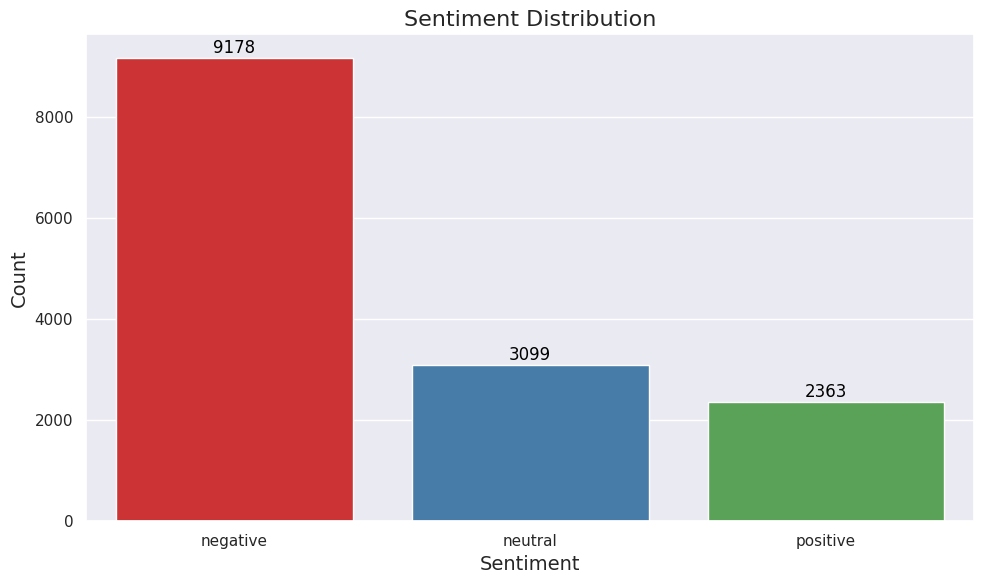

In [51]:
if 'airline_sentiment' in df.columns:
    # Calculate sentiment counts and prepare data
    sentiment_counts = df['airline_sentiment'].value_counts().reset_index()
    sentiment_counts.columns = ['Sentiment', 'Count']

    # Set up the Seaborn style and create the plot
    plt.figure(figsize=(10, 6))
    sns.set_theme(style="darkgrid")
    ax = sns.barplot(x='Sentiment', y='Count', data=sentiment_counts, palette="Set1")
    plt.title("Sentiment Distribution", fontsize=16)
    plt.xlabel("Sentiment", fontsize=14)
    plt.ylabel("Count", fontsize=14)
    plt.tight_layout()

    # Annotate each bar with its count value
    for index, row in sentiment_counts.iterrows():
        ax.text(index, row['Count'] + max(sentiment_counts['Count']) * 0.01,
                row['Count'], color='black', ha="center", fontsize=12)
    
    plt.show()


# Analyzing airline distribution

In [37]:
if 'airline' in df.columns:
    print("\nTweets by airline:")
    airline_counts = df['airline'].value_counts()
    print(airline_counts)


Tweets by airline:
airline
United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: count, dtype: int64


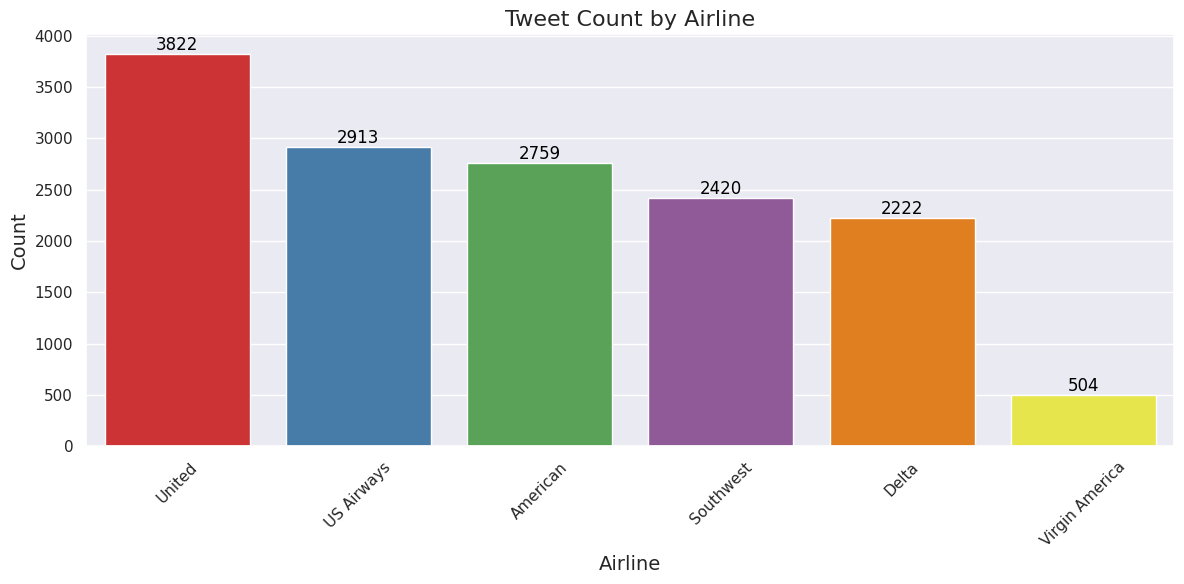

In [52]:
if 'airline' in df.columns:
    # Prepare data for airline tweet counts
    airline_counts = df['airline'].value_counts().reset_index()
    airline_counts.columns = ['Airline', 'Count']

    # Create the Seaborn bar plot
    plt.figure(figsize=(12, 6))
    sns.set_theme(style="darkgrid")
    ax = sns.barplot(x='Airline', y='Count', data=airline_counts, palette="Set1")
    plt.title("Tweet Count by Airline", fontsize=16)
    plt.xlabel("Airline", fontsize=14)
    plt.ylabel("Count", fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Annotate each bar with its count
    for index, row in airline_counts.iterrows():
        ax.text(index, row['Count'] + max(airline_counts['Count']) * 0.01,
                row['Count'], color='black', ha="center", fontsize=12)
    
    plt.show()


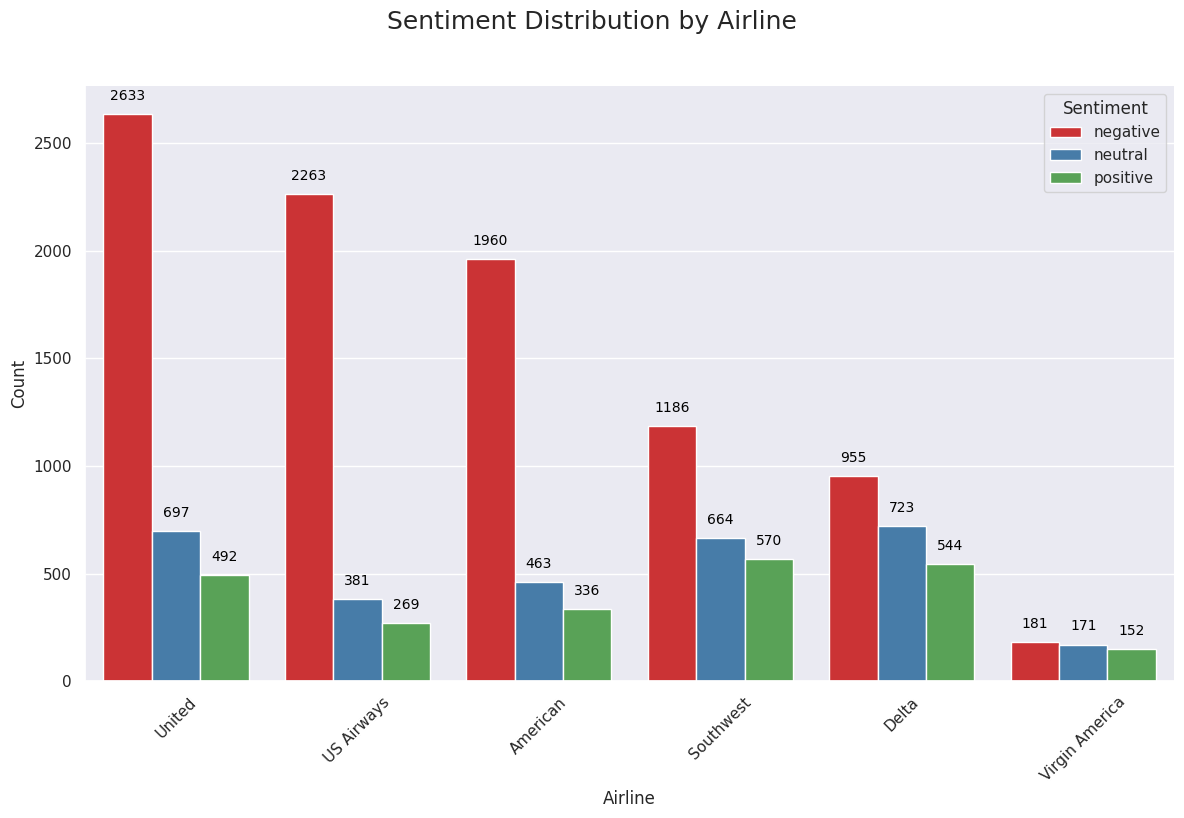

In [54]:
if 'airline' in df.columns and sentiment_column:
    # Group data by airline and sentiment
    sentiment_airline_counts = df.groupby(['airline', sentiment_column]).size().reset_index(name='Count')
    
    # Determine ordering of airlines based on overall tweet volume
    airline_order = sentiment_airline_counts.groupby('airline')['Count'].sum().sort_values(ascending=False).index.tolist()
    
    # Set the context for larger, clearer plots
    sns.set_context("talk")
    sns.set_theme(style="darkgrid")
    
    # Create an advanced categorical bar plot using catplot
    g = sns.catplot(
        data=sentiment_airline_counts, 
        kind='bar', 
        x='airline', y='Count', 
        hue=sentiment_column,
        order=airline_order,
        palette="Set1", 
        height=8, aspect=1.5,
        legend_out=False
    )
    
    # Set axis labels and title with improved typography
    g.set_axis_labels("Airline", "Count")
    g.fig.suptitle("Sentiment Distribution by Airline", fontsize=18, y=1.02)
    plt.xticks(rotation=45)
    
    # Annotate each bar with its count value
    ax = g.ax
    for p in ax.patches:
        # p.get_height() is the bar height (i.e., Count)
        height = p.get_height()
        ax.annotate(f'{int(height)}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom',
                    xytext=(0, 8), textcoords='offset points',
                    fontsize=10, color='black')
    
    plt.legend(title="Sentiment")
    plt.tight_layout()
    plt.show()


# Cleaning the text data

In [40]:
print("\nCleaning tweet text...")
text_column = 'text'
if text_column in df.columns:
    df['clean_text'] = df[text_column].apply(clean_text)
    
    # Show examples of original and cleaned text
    print("\nOriginal vs Cleaned Text Examples:")
    print(df[[text_column, 'clean_text']].head(3))
else:
    print(f"Could not find '{text_column}' column. Please specify the text column name.")


Cleaning tweet text...

Original vs Cleaned Text Examples:
                                                text  \
0                @VirginAmerica What @dhepburn said.   
1  @VirginAmerica plus you've added commercials t...   
2  @VirginAmerica I didn't today... Must mean I n...   

                             clean_text  
0                                   say  
1  plus add commercial experience tacky  
2                  today mean need trip  


 # Preparing data for model building

In [41]:
if sentiment_column and 'clean_text' in df.columns:
    X = df['clean_text']
    y = df[sentiment_column]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"Training set size: {len(X_train)}")
    print(f"Testing set size: {len(X_test)}")

Training set size: 11712
Testing set size: 2928


In [42]:
if 'X_train' in locals():
    vectorizer = TfidfVectorizer(max_features=5000)
    X_train_vectorized = vectorizer.fit_transform(X_train)
    X_test_vectorized = vectorizer.transform(X_test)
    
    print(f"Training features shape: {X_train_vectorized.shape}")
    print(f"Testing features shape: {X_test_vectorized.shape}")

Training features shape: (11712, 5000)
Testing features shape: (2928, 5000)


# Training the sentiment analysis model

In [43]:
if 'X_train_vectorized' in locals():
    model = LogisticRegression(max_iter=1000, class_weight='balanced')
    model.fit(X_train_vectorized, y_train)
    
    print("Model training complete!")

Model training complete!


# Evaluation


Model Evaluation:
              precision    recall  f1-score   support

    negative       0.90      0.77      0.83      1835
     neutral       0.52      0.69      0.59       620
    positive       0.64      0.70      0.67       473

    accuracy                           0.74      2928
   macro avg       0.68      0.72      0.70      2928
weighted avg       0.77      0.74      0.75      2928



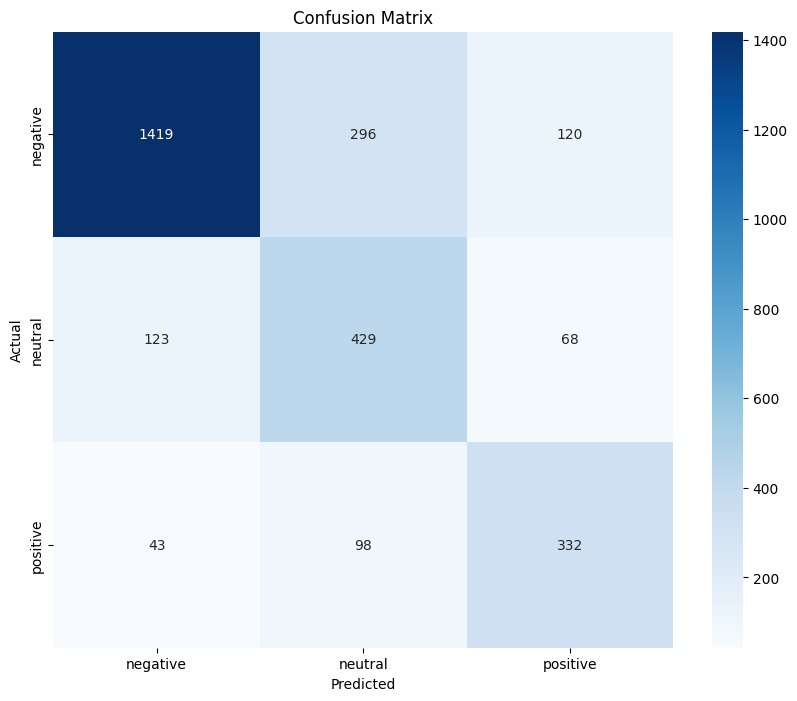

In [44]:
if 'model' in locals():
    y_pred = model.predict(X_test_vectorized)
    
    print("\nModel Evaluation:")
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=model.classes_,
                yticklabels=model.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Define function to predict sentiment for new tweets

In [45]:
if 'model' in locals() and 'vectorizer' in locals():
    def predict_sentiment(tweets, vectorizer=vectorizer, model=model):
        """Predict sentiment for new tweets"""
        if isinstance(tweets, str):
            tweets = [tweets]
            
        processed_tweets = [clean_text(tweet) for tweet in tweets]
        tweet_vectors = vectorizer.transform(processed_tweets)
        predictions = model.predict(tweet_vectors)
        probabilities = model.predict_proba(tweet_vectors)
        
        results = []
        for i, pred in enumerate(predictions):
            result = {
                'text': tweets[i],
                'sentiment': pred,
                'probability': max(probabilities[i])
            }
            results.append(result)
        
        if len(tweets) == 1:
            return results[0]
        return results

# Test

In [46]:
if 'predict_sentiment' in locals():
    example_tweets = [
        "Your airline service was amazing! Thank you for the wonderful experience.",
        "Terrible flight experience, delayed for hours with no explanation.",
        "The flight was okay, nothing special."
    ]
    
    print("Example sentiment predictions:")
    for tweet in example_tweets:
        result = predict_sentiment(tweet)
        print(f"Tweet: {tweet}")
        print(f"Predicted sentiment: {result['sentiment']} (confidence: {result['probability']:.2f})\n")

Example sentiment predictions:
Tweet: Your airline service was amazing! Thank you for the wonderful experience.
Predicted sentiment: positive (confidence: 1.00)

Tweet: Terrible flight experience, delayed for hours with no explanation.
Predicted sentiment: negative (confidence: 0.99)

Tweet: The flight was okay, nothing special.
Predicted sentiment: neutral (confidence: 0.83)



-----------------------------------------------------------------------

# Creating a function to analyze sentiment for a specific airline

In [49]:
if 'model' in locals() and 'vectorizer' in locals() and 'airline' in df.columns:
    def analyze_airline_sentiment(airline_name, data=df):
        """Analyze sentiment patterns for a specific airline"""
        airline_data = data[data['airline'].str.lower() == airline_name.lower()]
        
        if len(airline_data) == 0:
            return f"No data found for airline: {airline_name}"
        
        sentiment_dist = airline_data[sentiment_column].value_counts(normalize=True) * 100
        
        plt.figure(figsize=(10, 6))
        sns.countplot(x=sentiment_column, data=airline_data)
        plt.title(f'Sentiment Distribution for {airline_name}')
        plt.ylabel('Count')
        plt.show()
        
        word_freq = {}
        for sentiment in airline_data[sentiment_column].unique():
            sentiment_tweets = airline_data[airline_data[sentiment_column] == sentiment]['clean_text']
            all_words = ' '.join(sentiment_tweets).split()
            word_counts = pd.Series(all_words).value_counts().head(10)
            
            word_freq[sentiment] = word_counts
            
            plt.figure(figsize=(12, 6))
            word_counts.plot(kind='bar')
            plt.title(f'Top 10 Words in {sentiment} Tweets for {airline_name}')
            plt.ylabel('Frequency')
            plt.show()
        
        return {
            'total_tweets': len(airline_data),
            'sentiment_distribution': sentiment_dist.to_dict(),
            'common_words': word_freq
        }

# **EXAMPLE.**

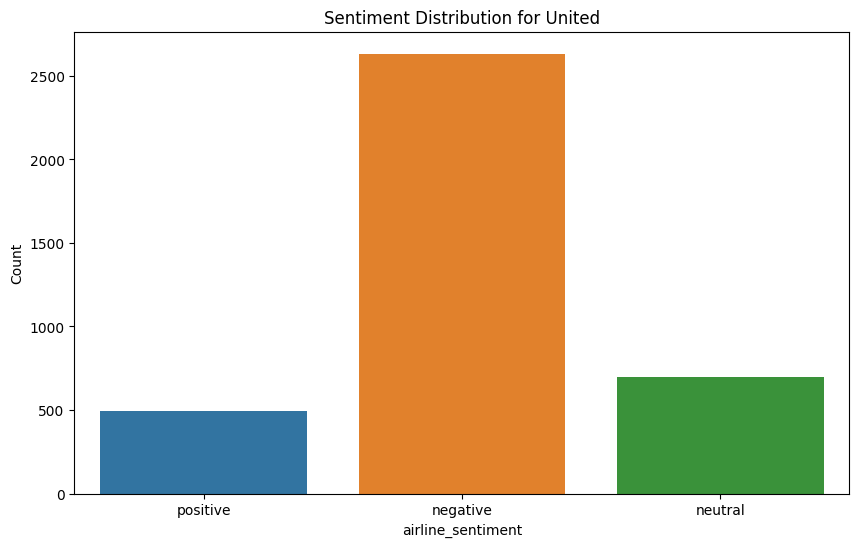

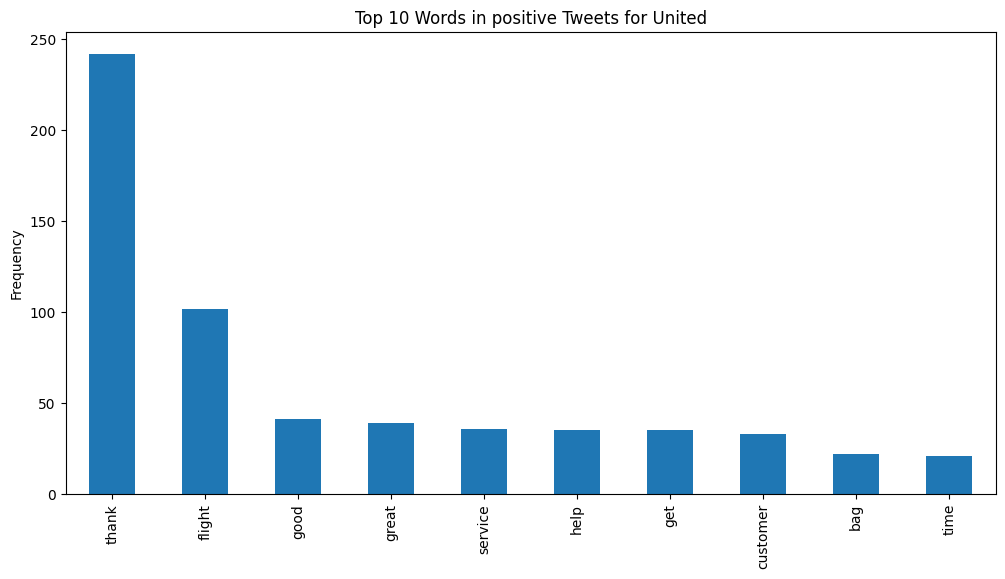

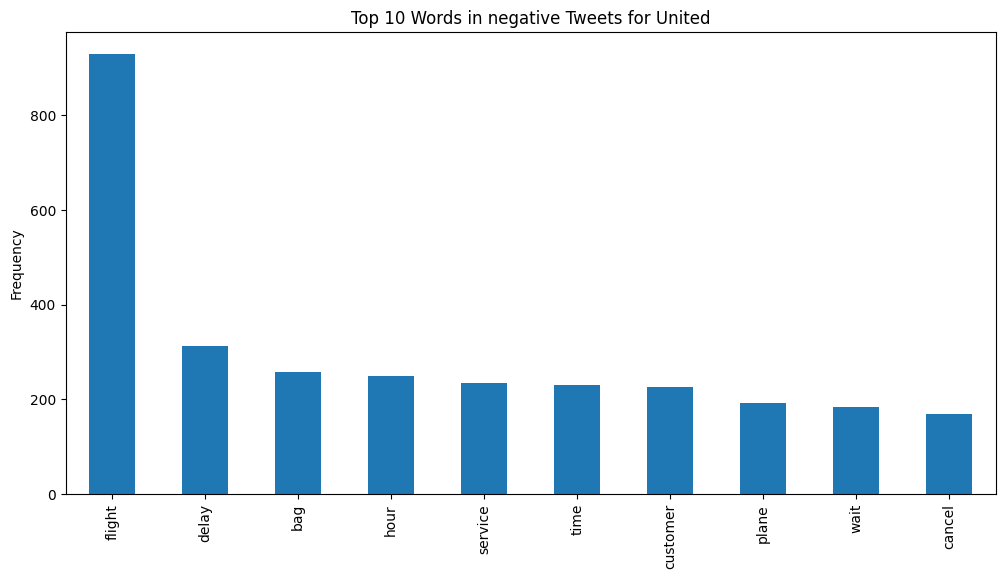

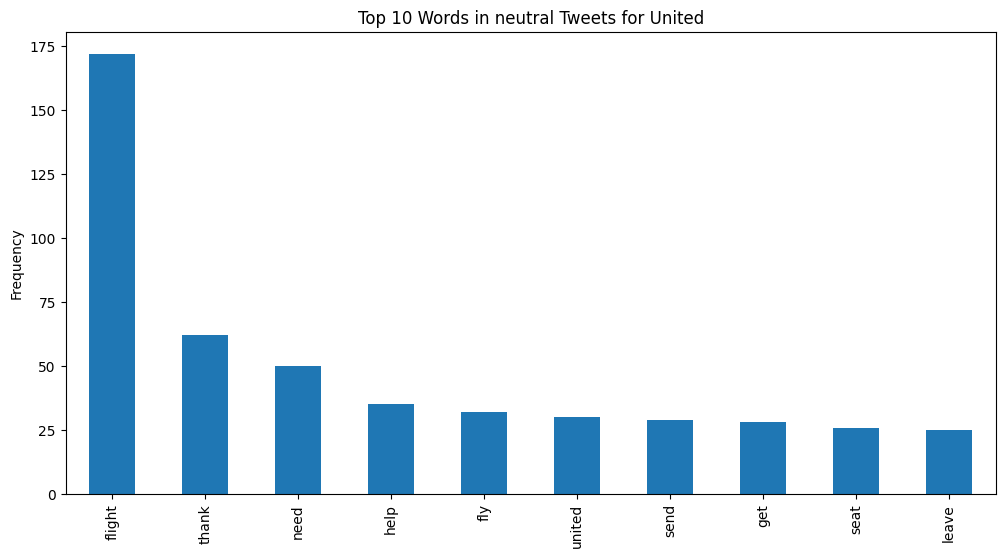

In [48]:
results = analyze_airline_sentiment("United")